### Step 3: Cleaning the data for input into a M.L algorithm.

In [222]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import torch
import torch.nn.functional as fun
from sklearn.feature_extraction.text import CountVectorizer
import re

In [223]:
latinamerican_art = pd.read_csv('../data_samples/LaArt/latinamerican_art.csv')

imagefp_exists = pd.read_csv('../data_samples/LaArt/validLa_image_fpaths.csv')

stored_la_art = imagefp_exists.where(imagefp_exists.imagefp_exists == True).dropna(how='all')
stored_la_art.reset_index(drop = True, inplace=True)

valid_image_paths = stored_la_art.shape[0]
la_art_total = latinamerican_art.shape[0]

In [224]:
print('After step 2: downloading, the amount of latin american images downloaded and successfully stored is {} out of {} starting records. The '.format(valid_image_paths, la_art_total))

After step 2: downloading, the amount of latin american images downloaded and successfully stored is 202 out of 342 starting records. The 


In [225]:
latinamerican_art_stored = pd.merge(left=latinamerican_art, right=stored_la_art, on = 'objectid', how = 'inner')

## Exploratory Data Analysis

### Amount of NA/Null Values per Feature in the Dataset

In [36]:
num_nulls = pd.isna(latinamerican_art_stored)

In [37]:
num_nulls = num_nulls.sum() / len(num_nulls)

In [38]:
num_nulls = num_nulls.sort_values(ascending=False).where(num_nulls > 0).dropna()

In [39]:
num_nulls

assistivetext               1.000000
volume                      1.000000
country_artistAssigned      1.000000
zipcode_artistAssigned      1.000000
watermarks                  0.968504
markings                    0.811024
series                      0.728346
parentID                    0.700787
inscription                 0.496063
portfolio                   0.484252
endyear_artistAssigned      0.314961
deathyear                   0.314961
dimensions                  0.275591
maxpixels                   0.212598
ulanid                      0.196850
beginyear_artistAssigned    0.059055
birthyear                   0.059055
displayDate_created         0.039370
dtype: float64

### Dataset Distributions

In [252]:
latinamerican_art_stored.shape

(248, 57)

#### To Do: Make a plot of time, or of image dimensions, in a seperate EDA notebook.

In [45]:
works_by_artist = latinamerican_art_stored.groupby('forwarddisplayname').apply(len)

In [48]:
works_by_continent = latinamerican_art_stored.groupby('artists_continent').apply(len).sort_values(ascending=True)

In [50]:
works_by_country = latinamerican_art_stored.groupby('artists_country').apply(len).sort_values(ascending=True)

<Axes: ylabel='artists_continent'>

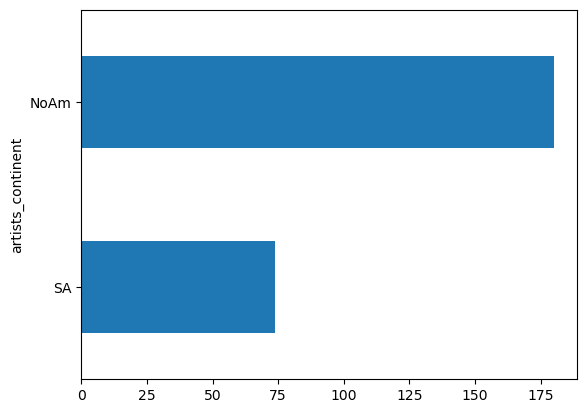

In [52]:
works_by_continent.plot(kind='barh')

<Axes: ylabel='artists_country'>

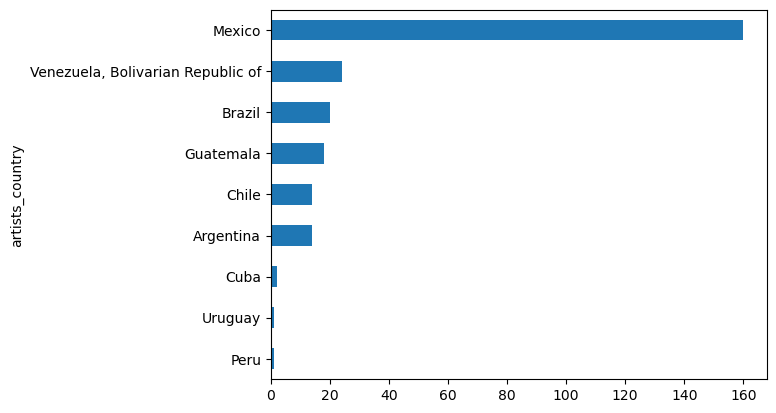

In [53]:
works_by_country.plot(kind='barh')

In [56]:
display(works_by_artist.sort_values(ascending=False).head())

forwarddisplayname
Manuel Álvarez Bravo    23
Leopoldo Méndez         21
Graciela Iturbide       17
Jesús Rafael Soto       16
Francisco Toledo        15
dtype: int64

In [57]:
display(works_by_artist.describe())

count    51.000000
mean      4.980392
std       5.728840
min       1.000000
25%       1.000000
50%       3.000000
75%       6.500000
max      23.000000
dtype: float64

## Text/Categorical Feature Engineering (en_translation tbd - most have english translations but not all)

In [226]:
latinamerican_art_stored.columns

Index(['iiifurl', 'iiifthumburl', 'accessioned', 'title',
       'displayDate_created', 'roletype', 'role', 'forwarddisplayname',
       'birthyear', 'deathyear', 'ulanid', 'artistofngaobject', 'nationality',
       'constituenttype', 'demonym', 'pct_country_NGA', 'artists_countryCode',
       'artists_continent', 'artists_country', 'beginyear_artistAssigned',
       'endyear_artistAssigned', 'displaydate_artistAssigned',
       'country_artistAssigned', 'zipcode_artistAssigned', 'medium',
       'dimensions', 'inscription', 'markings', 'attribution',
       'visualBrowserClassification', 'parentID', 'isVirtual', 'portfolio',
       'series', 'volume', 'watermarks', 'uuid', 'viewtype', 'sequence',
       'width', 'height', 'maxpixels', 'assistivetext', 'depictstmsobjectid',
       'objectid', 'constituentid', 'expanded_url', 'file_name', 'directory',
       'subfolder', 'image_fp', 'imagefp_exists'],
      dtype='object')

In [227]:
text_dict = {}
for entry in latinamerican_art_stored.title:
    entry_words = entry.split(' ')
    for word in entry_words:
        word = word.strip(')([],\./')
        word = word.lower()
        if word in text_dict.keys():
            text_dict[word] += 1
        else:
            text_dict[word] = 1

In [228]:
title_occurrences = pd.Series(text_dict).sort_values(ascending=False)

In [229]:
titles = latinamerican_art_stored.title.copy()

In [230]:
def clean_words(text):
    def strip(string):
        return re.sub('(?:^[{\W}]+)|(?:[{\W}]+$)', '', string)
    text_arr = text.split(' ')
    words = []
    for word in text_arr:
        edited = strip(word)
        words.append(edited.lower())
    return ' '.join(words)

In [231]:
#cleaning and formatting the data to give uniformity and clarity
titles = titles.apply(clean_words)

In [232]:
titles.head()

0    garden of hecelchácan
1       calavera maderista
2                     head
3                  lunaire
4                     head
Name: title, dtype: object

### Converting text into tokens and making one-hot for word generalization across titles, medium, country origin, and artist name

In [233]:
one_hot_vectorizer = CountVectorizer(binary=True)
one_hot = one_hot_vectorizer.fit_transform(titles)

title_oh = pd.DataFrame(one_hot.toarray().tolist(), columns=one_hot_vectorizer.get_feature_names_out())

one_hot = one_hot_vectorizer.fit_transform(latinamerican_art_stored.medium)
# Handling Duplicate Token Names in Columns (OH)
medium_cols = [x + ' (medium)' for x in one_hot_vectorizer.get_feature_names_out()]
medium_oh = pd.DataFrame(one_hot.toarray().tolist(), columns = medium_cols)

one_hot = one_hot_vectorizer.fit_transform(latinamerican_art_stored['artists_country'], )
# Handling Duplicate Token Names in Columns (OH)
country_cols = [x + ' (country)' for x in one_hot_vectorizer.get_feature_names_out()]
country_oh = pd.DataFrame(one_hot.toarray().tolist(), columns = country_cols)

one_hot = one_hot_vectorizer.fit_transform(latinamerican_art_stored['forwarddisplayname'])
# Handling Duplicate Token Names in Columns (OH)
name_cols = [x + ' (artist)' for x in one_hot_vectorizer.get_feature_names_out()]
artist_oh = pd.DataFrame(one_hot.toarray().tolist(), columns = name_cols)

oh_collection = pd.concat([title_oh, medium_oh, artist_oh, country_oh], axis=1)

In [234]:
oh_collection.head()

,17,1962,1972,1977,25,5x,abandonado,abandoned,aid,alarma,...,bolivarian (country),brazil (country),chile (country),cuba (country),guatemala (country),mexico (country),of (country),peru (country),republic (country),venezuela (country)
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### FE of Numerical Data

### feature containing % dataset created by individual artists

In [235]:
import scipy.stats as stats

In [236]:
percent_by_artist = latinamerican_art_stored.forwarddisplayname.value_counts(normalize='True')
artist_zscore = stats.zscore(percent_by_artist)
latinamerican_art_stored['artist_zscore'] = latinamerican_art_stored.forwarddisplayname.apply(lambda x: artist_zscore[x])
latinamerican_art_stored['percent_by_artist'] = latinamerican_art_stored.forwarddisplayname.apply(lambda x: percent_by_artist[x])
latinamerican_art_stored['log_percent_by_artist'] = latinamerican_art_stored['percent_by_artist'].apply(lambda x: np.log(x + 1))
latinamerican_art_stored['log_width'] = latinamerican_art_stored['width'].apply(lambda x: np.log(x + 1))
latinamerican_art_stored['log_height'] = latinamerican_art_stored['height'].apply(lambda x: np.log(x + 1))
numerical_cols = ['log_width', 'log_height', 'log_percent_by_artist']
numerical_data = latinamerican_art_stored.loc[:, numerical_cols]

### Final Collection of Transformed data

In [238]:
imagefp_features = ['imagefp_exists','objectid']

In [253]:
latinamerican_art_stored.shape

(248, 57)

In [240]:
la_image_data = latinamerican_art_stored.loc[:, imagefp_features]

In [251]:
print('Merging the following: ')
print('imagefp data shape: ', la_image_data.shape)
print('one-hot data shape: ', oh_collection.shape)
print('numerical data shape: ', numerical_data.shape)

Merging the following: 
imagefp data shape:  (248, 2)
one-hot data shape:  (248, 600)
numerical data shape:  (248, 3)


In [247]:
transformed_data = pd.concat([la_image_data, oh_collection, numerical_data], axis=1)

In [248]:
transformed_data.head()

,imagefp_exists,objectid,17,1962,1972,1977,25,5x,abandonado,abandoned,...,cuba (country),guatemala (country),mexico (country),of (country),peru (country),republic (country),venezuela (country),log_width,log_height,log_percent_by_artist
0,True,33520.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,8.294300,8.133294,0.035647
1,True,30476.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,7.499423,8.294300,0.019961
2,True,64175.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,7.975565,8.294300,0.035647
3,True,58985.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8.294300,8.081784,0.016000
4,True,64170.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,7.982075,8.294300,0.035647


In [249]:
transformed_data.to_csv('../data_samples/LaArt/transformed_la_art.csv', index=False)

In [254]:
print('Final shape of transformed data (including imagefp_exists and objectid columns)', transformed_data.shape)

Final shape of transformed data (including imagefp_exists and objectid columns) (248, 605)
